In [1]:
import geopandas as gpd
import fiona
from shapely.geometry import shape
import matplotlib.pyplot as plt

def load_valid_geometries(shapefile_path):
    """
    加载 shapefile 并过滤掉非法的 LineString 几何对象。

    参数:
        shapefile_path (str): shapefile 文件的路径

    返回:
        GeoDataFrame: 包含合法几何体和属性的 GeoDataFrame
    """
    features = []

    with fiona.open(shapefile_path) as src:
        for feature in src:
            geom_info = feature['geometry']
            geom_type = geom_info['type']
            coords = geom_info['coordinates']

            # 跳过非法 LineString（无坐标或坐标点不足）
            if geom_type == 'LineString' and (not coords or len(coords) < 2):
                continue

            # 转为 shapely geometry 对象
            geom = shape(geom_info)

            features.append({
                'geometry': geom,
                **feature['properties']
            })

    return gpd.GeoDataFrame(features)

abila_gdf = load_valid_geometries("./Geospatial/Abila.shp")


In [4]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
import re
from shapely.geometry import LineString, Point
import folium
from shapely.ops import unary_union


def parse_address(location):
    """解析地址字符串，返回结构化信息"""
    location = location.strip()

    # 交叉口形式
    if '/' in location:
        streets = [s.strip() for s in location.split('/')]
        return {'type': 'intersection', 'streets': streets}

    # 门牌号形式（或不带门牌号的普通地址）
    # 示例：4607 N. Barwyn St
    # 示例：N. Polvo St
    # 示例：Egeou Ave

    match = re.match(
        r"""^\s*
    (?:(\d+)\s+)?                         # 门牌号（可选）
    (?:(N|S|E|W|NE|NW|SE|SW)\.?\s+)?      # 方向前缀（可选）
    ([\w\s\-']+?)                         # 街道名称
    \s+(\w+)\.?\s*$                       # 放宽街道类型匹配（如 Pky, Pkwy, Av, etc.）
    """, location, re.IGNORECASE | re.VERBOSE
    )

    if not match:
        return None

    number, dir_prefix, name, st_type = match.groups()
    return {
        'type': 'address',
        'number': int(number) if number else None,
        'FEDIRP': dir_prefix.upper() if dir_prefix else None,
        'FENAME': name.strip(),
        'FETYPE': st_type
    }


def get_location_coords(location, abila_gdf):
    parsed = parse_address(location)
    # print(f"解析地址: {location} -> {parsed}")
    if not parsed:
        return None

    if parsed['type'] == 'intersection':
        streets = []
        for street in parsed['streets']:
            s = parse_address(street)
            if not s:
                return None
            # cond = (
            #     (abila_gdf['FENAME'].str.lower() == s['FENAME'].lower()) &
            #     (abila_gdf['FETYPE'].str.lower() == s['FETYPE'].lower())
            # )
            cond = ((abila_gdf['FENAME'].str.lower() == s['FENAME'].lower()))
            if s['FEDIRP']:
                cond &= (abila_gdf['FEDIRP'].str.upper()
                         == s['FEDIRP'].upper())
            match = abila_gdf[cond]
            if match.empty:
                print(f"❌ 找不到街道: {street}")
                return None
            streets.append(match)

        # 将所有匹配的线合并成一条（支持 MultiLine）
        line1 = unary_union(streets[0].geometry.tolist())
        line2 = unary_union(streets[1].geometry.tolist())

        # 计算交点
        intersection = line1.intersection(line2)

        # 返回第一个有效交点
        if isinstance(intersection, Point):
            return intersection.x, intersection.y
        elif intersection.geom_type == 'MultiPoint':
            return list(intersection.geoms)[0].x, list(intersection.geoms)[0].y
        elif intersection.geom_type == 'GeometryCollection':
            for geom in intersection.geoms:
                if isinstance(geom, Point):
                    return geom.x, geom.y
        print(f"⚠️ 没找到交点: {location}")
        return None

    elif parsed['type'] == 'address':
        # cond = (
        #     (abila_gdf['FENAME'].str.lower() == parsed['FENAME'].lower()) &
        #     (abila_gdf['FETYPE'].str.lower() == parsed['FETYPE'].lower())
        # )
        cond = ((abila_gdf['FENAME'].str.lower() == parsed['FENAME'].lower()))
        if parsed['FEDIRP']:
            cond &= (abila_gdf['FEDIRP'].str.upper()
                     == parsed['FEDIRP'].upper())
        matches = abila_gdf[cond]
        if matches.empty:
            print("❌ 没有匹配的街道段")
            return None

        if parsed['number'] is None:
            print("⚠️ 地址中不包含门牌号，无法精确定位")
            return None

        for _, row in matches.iterrows():
            addr_num = parsed['number']
            left = row.get('FRADDL'), row.get('TOADDL')
            right = row.get('FRADDR'), row.get('TOADDR')
            all_nums = list(filter(None, left + right))
            if not all_nums:
                continue
            min_num, max_num = min(all_nums), max(all_nums)
            if min_num <= addr_num <= max_num:
                # 返回线段中心
                midpoint = row.geometry.interpolate(0.5, normalized=True)
                return midpoint.x, midpoint.y

        print("❌ 不在范围内")
        return None

# import folium
# from IPython.display import display  # 仅用于 Jupyter

# def plot_locations_on_map(location_list, abila_gdf):
#     """画出街道地图和标记位置，并直接展示"""
#     m = folium.Map(location=[36.05, 24.84], zoom_start=15)

#     # 加入街道线
#     for geom in abila_gdf.geometry:
#         if isinstance(geom, LineString):
#             folium.PolyLine(locations=[(y, x) for x, y in geom.coords], color="gray", weight=1).add_to(m)

#     # 添加每个 location 的坐标点
#     for loc in location_list:
#         coords = get_location_coords(loc, abila_gdf)
#         if coords:
#             folium.Marker(
#                 location=(coords[1], coords[0]),
#                 popup=loc,
#                 icon=folium.Icon(color="red", icon="map-marker")
#             ).add_to(m)
#         else:
#             print(f"❗ 无法定位: {loc}")

#     display(m)


def plot_locations_on_map(location_list, abila_gdf):
    """使用 matplotlib 画出街道网络并标注位置"""
    fig, ax = plt.subplots(figsize=(10, 10))

    # 画街道线（GeoDataFrame 自带 plot 方法）
    abila_gdf.plot(ax=ax, linewidth=0.8, color='lightgray')

    # 标记所有地址点
    for loc in location_list:
        coords = get_location_coords(loc, abila_gdf)
        if coords:
            x, y = coords
            ax.plot(x, y, 'ro')  # 红色圆点
            ax.text(x + 0.0005, y + 0.0005, loc, fontsize=9)
        else:
            print(f"❗ 无法定位: {loc}")

    ax.set_title("Abila City Map with Locations", fontsize=15)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    plt.grid(True)
    plt.show()

(24.90051500000002, 36.054221)


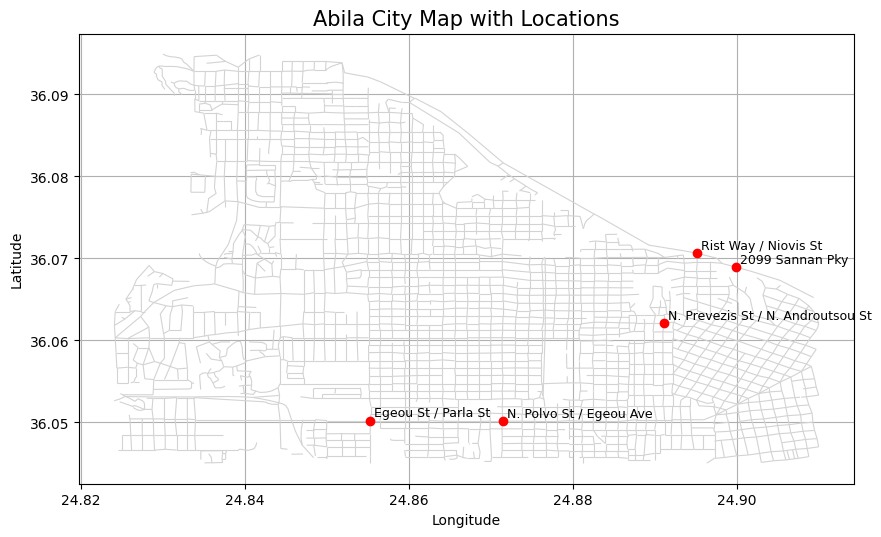

In [3]:
# 单个坐标获取
coord = get_location_coords("500 N. Schaber Ave", abila_gdf)
print(coord)

# 多个位置地图可视化
locations = [
    "2099 Sannan Pky",
    "N. Polvo St / Egeou Ave",
    "N. Prevezis St / N. Androutsou St",
    "Rist Way / Niovis St",
    "Egeou St / Parla St",
]
plot_locations_on_map(locations, abila_gdf)


📌 提取了 152 个有效地址。
❌ 不在范围内
❗ 无法定位: 3703 N. Pilau St
❗ 无法定位: N. Parla St from Egeou Ave North to N. Alm St
❌ 找不到街道: N. Pilai St
❗ 无法定位: N. Carnero St / N. Pilai St
❌ 没有匹配的街道段
❗ 无法定位: ALL UNITS
❌ 不在范围内
❗ 无法定位: 2299 N. Finiatur St


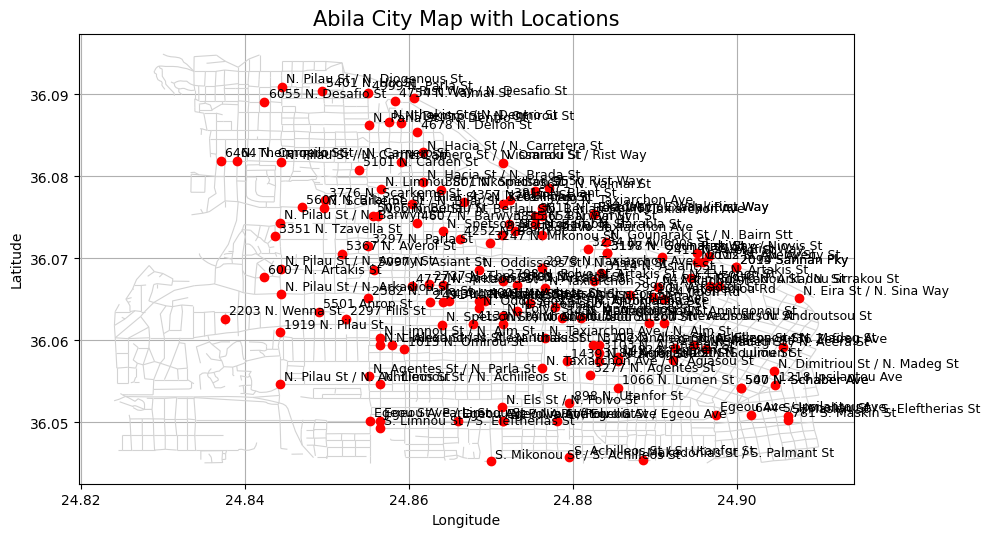

In [4]:
import pandas as pd
df1 = pd.read_csv("./csv-1700-1830.csv", encoding='latin1')
df2 = pd.read_csv("./csv-1831-2000.csv", encoding='latin1')
df3 = pd.read_csv("./csv-2001-2131.csv", encoding='latin1')
df = pd.concat([df1, df2, df3], ignore_index=True)
location_list = df[' location'].dropna().astype(str).unique().tolist()

print(f"📌 提取了 {len(location_list)} 个有效地址。")
# print(location_list)
plot_locations_on_map(location_list, abila_gdf)

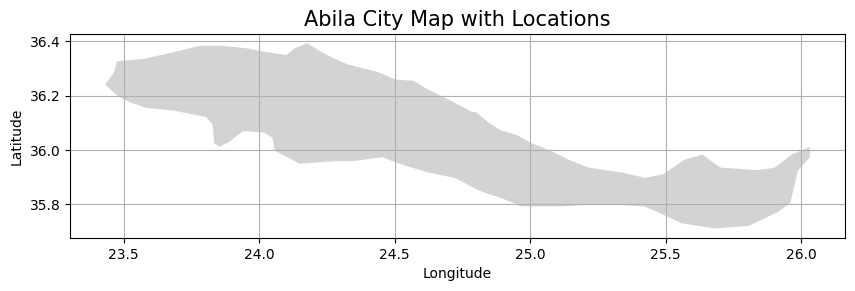

In [5]:
kronos_gdf = load_valid_geometries("./Geospatial/Kronos_Island.shp")
plot_locations_on_map([], kronos_gdf)

In [90]:
import re
import numpy as np

class MBDATA:
    def __init__(self, date, author, message, latitude=None, longitude=None):
        self.date = date
        self.author = author
        self.message = message
        if pd.isna(latitude) and pd.isna(longitude):
            self.location = None
        else:
            self.location = Point(longitude, latitude)

        # Parsed fields
        self.is_retweet = False
        self.retweet_author = None
        self.retweet_text = None
        self.mentions = []
        self.hashtags = []

        # Immediately parse message upon instantiation
        self.parse_message()

    def parse_message(self):
        """
        Populate:
          - is_retweet: bool
          - retweet_user: original author's username if RT
          - retweet_text: original message text if RT
          - mentions: list of usernames mentioned
          - hashtags: list of hashtags used
        """
        # Detect retweet pattern "RT @user: text"
        rt_match = re.match(r'^RT\s+@(?P<user>[\w\-]+)\s*(?P<text>.*)', self.message)
        if rt_match:
            self.is_retweet = True
            self.retweet_author = rt_match.group('user')
            self.retweet_text = rt_match.group('text')

        # Extract all @mentions and #hashtags
        self.mentions = re.findall(r'@(\w+)', self.message)
        self.hashtags = re.findall(r'#(\w+)', self.message)

    def to_dict(self):
        """
        Return all data as a dict, useful for DataFrame construction.
        """
        return {
            'date': self.date,
            'author': self.author,
            'message': self.message,
            'location': self.location,
            'is_retweet': self.is_retweet,
            'retweet_author': self.retweet_author,
            'retweet_text': self.retweet_text,
            'mentions': self.mentions,
            'hashtags': self.hashtags
        }

In [ ]:
class CCDATA:
    def __init__(self, date, message, location=None):
        self.date = date
        self.message = message
        self.location = location

        # Parsed fields
        self.incident_type = None
        self.status = None
        self.details = None

        self.parse_message()

    def parse_message(self):
        # Define common status and priority indicators
        status_keywords = ['IN PROGRESS', 'REPORT', 'REQUEST', 'CONTINUES']
        
        # 统一
        replace_dict ={
            'PURSUIT CONTINUES': 'PURSUIT-CONTINUES',
            'CRIME SCENE INVESTIGATION-REQUEST': 'CRIME SCENE INVESTIGATION REQUEST',
            'POLICE UNIT DISPATCHED': 'POLICE UNITS DISPATCHED',
        }
        for old, new in replace_dict.items():
            self.message = self.message.replace(old, new)
        content = [d.strip() for d in self.message.split('-')]
        
        # Extract incident type
        self.incident_type = content[0] if content else None
        content.pop(0) 
    
        # Extract known status
        for status in status_keywords:
            if status in content:
                self.status = status
                content.remove(status)
                break
        # Remaining content
        self.details = content
        
    def to_dict(self):
        return {
            'date': self.date,
            'message': self.message,
            'location': self.location,
            'incident_type': self.incident_type,
            'status': self.status,
            'details': self.details
        }

In [7]:
import pandas as pd
df1 = pd.read_csv("./csv-1700-1830.csv", encoding='latin1')
df2 = pd.read_csv("./csv-1831-2000.csv", encoding='latin1')
df3 = pd.read_csv("./csv-2001-2131.csv", encoding='latin1')
df = pd.concat([df1, df2, df3], ignore_index=True)

用户画像分析

In [46]:
mbdata = df[df['type'] == 'mbdata']
mbdata

,type,date(yyyyMMddHHmmss),author,message,latitude,longitude,location
0,mbdata,20140123170000,POK,Follow us @POK-Kronos,NaN,NaN,NaN
1,mbdata,20140123170000,maha_Homeland,Don't miss a moment! Follow our live coverage...,NaN,NaN,NaN
2,mbdata,20140123170000,Viktor-E,Come join us in the Park! Music tonight at Abi...,NaN,NaN,NaN
3,mbdata,20140123170000,KronosStar,POK rally to start in Abila City Park. POK lea...,NaN,NaN,NaN
4,mbdata,20140123170000,AbilaPost,POK rally set to take place in Abila City Park...,NaN,NaN,NaN
...,...,...,...,...,...,...,...
4058,mbdata,20140123213310,plasticParts,RT @AbilaPost unknown explosion heard from the...,NaN,NaN,NaN
4059,mbdata,20140123213345,klingon4real,RT @CentralBulletin explosion heard at dancing...,NaN,NaN,NaN
4060,mbdata,20140123213400,lindyT,RT @KronosStar There has been an explosion fro...,NaN,NaN,NaN
4061,mbdata,20140123213400,dolls4sale,RT @redisrad What was that? #boom,NaN,NaN,NaN


In [91]:
mbdata_list = mbdata.to_dict(orient='records')
mbdata_list = [MBDATA(d['date(yyyyMMddHHmmss)'], d['author'], d['message'], d['latitude'], d['longitude']) for d in mbdata_list]
mbdata_df = pd.DataFrame([d.to_dict() for d in mbdata_list])
# mbdata_df.to_csv("./mbdata.csv", index=False, encoding='utf-8-sig')

In [9]:
ccdata = df[df['type'] == 'ccdata']
ccdata

,type,date(yyyyMMddHHmmss),author,message,latitude,longitude,location
9,ccdata,20140123170000,NaN,KEEP THE PEACE-CROWD CONTROL/ABILA CITY PARK,NaN,NaN,Egeou St / Parla St
28,ccdata,20140123170210,NaN,TRAFFIC STOP,NaN,NaN,N. Els St / N. Polvo St
59,ccdata,20140123170513,NaN,PARK CHECK,NaN,NaN,2099 Sannan Pky
123,ccdata,20140123171102,NaN,DISTURBANCE-NOISE,NaN,NaN,3654 N. Barwyn St
131,ccdata,20140123171153,NaN,ALARM-SECURE NO CRIME,NaN,NaN,3815 N. Blant St
...,...,...,...,...,...,...,...
3908,ccdata,20140123212111,NaN,DRUNK SUBJECT,NaN,NaN,2299 N. Finiatur St
3926,ccdata,20140123212200,NaN,CRIME SCENE INVESTIGATION-REQUEST-ADDITIONAL U...,NaN,NaN,1122 N. Maskin St
3983,ccdata,20140123212500,NaN,SUSPICIOUS SUBJECT/CIRCUMSTANCES-IN PROGRESS,NaN,NaN,S. Mikonou St / S. Achilleos St
4013,ccdata,20140123212712,NaN,TRAFFIC STOP,NaN,NaN,N. Pilau St / N. Diogenous St


In [65]:
ccdata_list = ccdata.to_dict(orient='records')
ccdata_list = [CCDATA(d['date(yyyyMMddHHmmss)'], d['message'], d[' location']) for d in ccdata_list]
ccdata_df = pd.DataFrame([d.to_dict() for d in ccdata_list])

### Step 1
**先从用户的角度筛选，目的是确定一些最相关用户和无关用户，可以直接对应到有价值的信息和无价值的信息**
1. 基本信息：总发帖数，总转发数，总被转发数
2. 单个用户发帖内容主题建模
3. 确定核心用户
4. 用户关联：扩展相关和无关用户
   + 转发关系
   + 主题相似度
5. 确定相关用户和无关用户

In [136]:
# 基本信息：总发帖数，总转发数，总被转发数
# 单个用户发帖内容主题建模
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter

class Author:
    def __init__(self, name, messages_df):
        """
        初始化作者对象
        :param name: 作者用户名
        :param messages_df: 包含所有 MBDATA 数据的 DataFrame
        """
        self.name = name
        self.df = messages_df[messages_df['author'] == name]
        self.original_df = self.df[~self.df['is_retweet']]
        self.retweet_df = self.df[self.df['is_retweet']]
        
        self.retweeted_by = messages_df[messages_df['retweet_author'] == name]
        self.mentioned_by = messages_df[messages_df['mentions'].apply(lambda lst: name in lst if lst else False)]

        # 基础统计
        self.total_posts = len(self.df)
        self.original_posts = len(self.original_df)
        self.retweet_posts = len(self.retweet_df)
        self.times_retweeted = len(self.retweeted_by)
        self.times_mentioned = len(self.mentioned_by)

        # 内容字段
        self.topics = []
        self.mentions = Counter()
        self.hashtags = Counter()

        self.extract_mentions_and_hashtags()
        self.topic_modeling()
    
    def extract_mentions_and_hashtags(self):
        all_mentions = self.df['mentions'].sum() if not self.df['mentions'].isna().all() else []
        all_hashtags = self.df['hashtags'].sum() if not self.df['hashtags'].isna().all() else []
        self.mentions = Counter(all_mentions)
        self.hashtags = Counter(all_hashtags)

    def topic_modeling(self, num_topics=3, num_words=5):
        """
        对作者的原创内容进行主题建模
        """
        messages = self.original_df['message'].dropna().tolist()
        if len(messages) < num_topics:
            return []

        vectorizer = CountVectorizer(stop_words='english', max_features=1000)
        X = vectorizer.fit_transform(messages)
        lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
        lda.fit(X)

        words = vectorizer.get_feature_names_out()
        self.topics = [
            [words[i] for i in topic.argsort()[-num_words:]]
            for topic in lda.components_
        ]
        return self.topics

    def summary(self):
        return {
            'author': self.name,
            'total_posts': self.total_posts,
            'original_posts': self.original_posts,
            'retweet_posts': self.retweet_posts,
            'times_retweeted': self.times_retweeted,
            'times_mentioned': self.times_mentioned,
            'top_mentions': self.mentions.most_common(5),
            'top_hashtags': self.hashtags.most_common(5),
            'topics': self.topics
        }

In [137]:
author_names = set(mbdata_df['author'].dropna().unique())
authors = {name: Author(name, mbdata_df) for name in author_names}

In [142]:
# 挖掘核心用户
from sklearn.preprocessing import MinMaxScaler

# 收集所有作者的发帖量和被转发次数
data = []
for name, author in authors.items():
    data.append(author.summary())

df_core = pd.DataFrame(data)

# 归一化处理
scaler = MinMaxScaler()
df_core[['norm_posts', 'norm_retweets']] = scaler.fit_transform(
    df_core[['total_posts', 'times_retweeted']]
)

# 加权计算核心得分（可调权重）
w1, w2 = 0.5, 0.5
df_core['core_score'] = w1 * df_core['norm_posts'] + w2 * df_core['norm_retweets']

# 排序输出前 10 核心用户
top_core = df_core.sort_values(by='core_score', ascending=False).head(10)

# 显示
# pd.set_option('display.max_rows', None)
# print("核心用户（发帖量 + 被转发量）Top 10：")
# print(top_core[['author', 'total_posts', 'times_retweeted', 'core_score', 'topics']])
for row in top_core.itertuples():
    print(f"{row.author}: total_posts {row.total_posts}, times_retweeted {row.times_retweeted}, core_score {row.core_score:.3f}, topics {row.topics}")

HomelandIlluminations: total_posts 65, times_retweeted 183, core_score 0.525, topics [['alexandrias', 'ithakis', 'corner', 'gunmen', 'apd'], ['report', 'control', 'word', 'residents', 'hi'], ['trapped', 'area', 'floor', 'door', 'hi']]
KronosQuoth: total_posts 1265, times_retweeted 0, core_score 0.500, topics [['things', 'kronosstar', 'success', 'hi', 'pokrally'], ['time', 'life', 'hi', 'kronosstar', 'pokrally'], ['say', 'people', 'hi', 'kronosstar', 'pokrally']]
AbilaPost: total_posts 72, times_retweeted 169, core_score 0.490, topics [['gelatogalore', 'arrived', 'reports', 'apd', 'abilapost'], ['rally', 'closed', 'apd', 'st', 'abilapost'], ['firefighters', 'police', 'dancingdolphin', 'pokrally', 'abilapost']]
KronosStar: total_posts 49, times_retweeted 143, core_score 0.410, topics [['near', 'galore', 'gelato', 'apd', 'kronosstar'], ['dolphin', 'abila', 'building', 'dancingdolphinfire', 'kronosstar'], ['scene', 'arrived', 'afdheroes', 'dancingdolphinfire', 'kronosstar']]
CentralBulleti

In [100]:
# 转发关系强度 (R1)
import networkx as nx

G_r1 = nx.DiGraph()
total_retweet_count = 0  # 用于归一化

# 构建图并计算总转发数
for author in authors.values():
    for _, row in author.retweet_df.iterrows():
        src = row['author']
        tgt = row['retweet_author']
        if src and tgt:
            total_retweet_count += 1
            if G_r1.has_edge(src, tgt):
                G_r1[src][tgt]['weight'] += 1
            else:
                G_r1.add_edge(src, tgt, weight=1)

# 归一化权重
for u, v in G_r1.edges():
    G_r1[u][v]['r1'] = G_r1[u][v]['weight'] / total_retweet_count


In [95]:
# Topic 相似度 (R2)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 为每个作者提取原创内容
author_msgs = {name: ' '.join(author.original_df['message'].dropna()) for name, author in authors.items()}

# 构建 TF-IDF 特征
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(author_msgs.values())

# 计算相似度矩阵（cosine）
sim_matrix = cosine_similarity(X)

# 映射用户名索引
names = list(author_msgs.keys())
G_r2 = nx.Graph()

for i in range(len(names)):
    for j in range(i+1, len(names)):
        sim = sim_matrix[i][j]
        if sim > 0:  # 过滤掉无关联
            G_r2.add_edge(names[i], names[j], weight=sim)


In [ ]:
# R1 R2 加权叠加
G_weighted = nx.Graph()
# 怎么确定合适的权重？
w_r1 = 0.2  # R1 权重
w_r2 = 0.8  # R2 权重

# 加入 r1（转发）信息，转为无向图处理（可调整为 directed）
for u, v, data in G_r1.edges(data=True):
    w = data['weight']
    G_weighted.add_edge(u, v, r1=w, r2=0, weight=w*w_r1)  # 初始仅r1

# 加入 r2（内容）信息
for u, v, data in G_r2.edges(data=True):
    sim = data['weight']
    if G_weighted.has_edge(u, v):
        G_weighted[u][v]['r2'] = sim
        G_weighted[u][v]['weight'] += sim*w_r2  # 加权叠加
    else:
        G_weighted.add_edge(u, v, r1=0, r2=sim, weight=sim*w_r2)


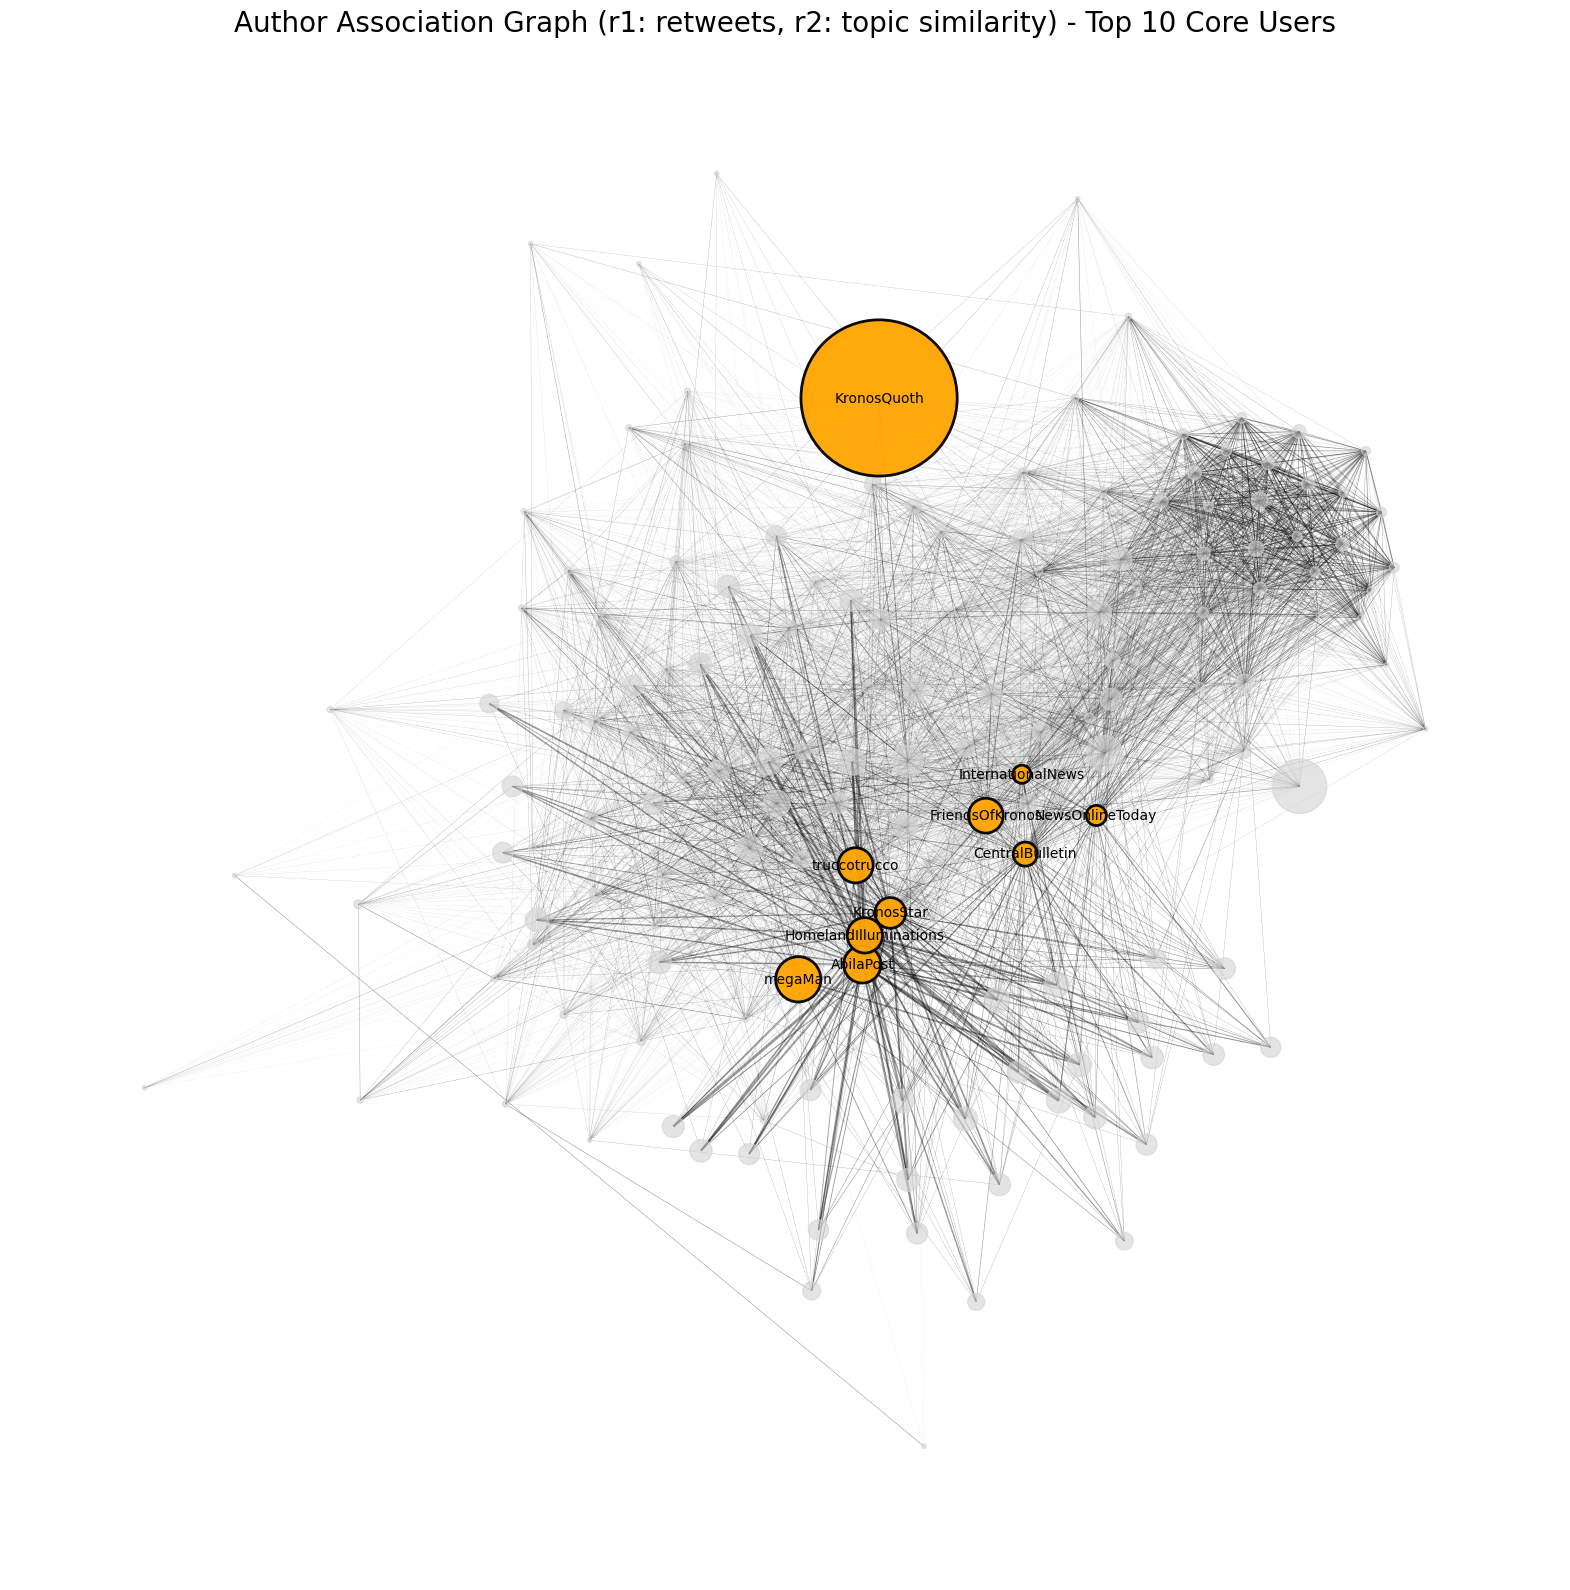

In [149]:
import matplotlib.pyplot as plt
import networkx as nx

# 假设你已经有 df_core 并计算了 core_score
# 取前 10 个核心用户
top_n = 10
core_users = set(
    df_core.sort_values(by='core_score', ascending=False)
    .head(top_n)['author']
)

# 获取图布局
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G_weighted, k=0.5, iterations=50)

# 边权重
weights = [G_weighted[u][v]['weight'] for u, v in G_weighted.edges()]
nx.draw_networkx_edges(G_weighted, pos, width=weights, alpha=0.4)

# 分离核心节点和其他节点
core_nodes = [n for n in G_weighted.nodes() if n in core_users]
other_nodes = [n for n in G_weighted.nodes() if n not in core_users]

# 绘制其他节点（无标签）
nx.draw_networkx_nodes(
    G_weighted, pos,
    nodelist=other_nodes,
    node_size=[authors[n].total_posts * 10 for n in other_nodes],
    node_color='lightgray',
    alpha=0.6
)

# 绘制核心节点（加粗边框、深色、显示标签）
nx.draw_networkx_nodes(
    G_weighted, pos,
    nodelist=core_nodes,
    node_size=[authors[n].total_posts * 10 for n in core_nodes],
    node_color='orange',
    edgecolors='black',
    linewidths=2.0,
    alpha=0.95
)

# 只为核心节点显示名字
labels = {n: n for n in core_nodes}
nx.draw_networkx_labels(G_weighted, pos, labels=labels, font_size=10)

plt.title("Author Association Graph (r1: retweets, r2: topic similarity) - Top 10 Core Users", fontsize=20)
plt.axis('off')
plt.show()



In [151]:
import community as community_louvain

# 计算社区划分（传入 G_weighted 和边的权重）
partition = community_louvain.best_partition(G_weighted, weight='weight')

In [152]:
from collections import defaultdict

# 打印社区成员
communities = defaultdict(list)
for node, comm_id in partition.items():
    communities[comm_id].append(node)

for comm_id, members in communities.items():
    print(f"社区 {comm_id}: {members}")


社区 0: ['dragonRider1', 'AbilaPost', 'CentralBulletin', 'HomelandIlluminations', 'KronosStar', 'InternationalNews', 'NewsOnlineToday', 'sarajane', 'vonneka', 'megaMan', 'soup4u', 'siliconKing', 'dtennent', 'farmboy', 'rnbwBrite', 'rrWine', 'microBanana', 'slamrjamr', 'klingon4real', 'pinky', 'joyce101', 'phantomagate', 'zengardener', 'lindyT', 'jgrobannne', 'wiseWords', 'ninjabob', 'blueSunshine', 'dolls4sale', 'luvMyPants', 'muppiesRock', 'worldWatcher', 'brain448', 'stolkfair', 'lordWally', 'gardener4958', 'jaques', 'henri', 'sithLordJames', 'vetsRock', 'brandonL', 'BlueVelvet', 'courage4life', 'electricAvenue', 'wireHead1122', 'plasticParts', 'hazMore445']
社区 1: ['MindOfKronos', 'choconibbs', 'POK', 'FriendsOfKronos', 'truthforcadau', 'maha_Homeland', 'ReggieWassali', 'anaregents', 'ourcountryourrights', 'footfingers', 'stuffNstuff', 'KronosQuoth', 'Clevvah4Evah']
社区 2: ['AbilaPoliceDepartment', 'roger_roger', 'prettyRain', 'sofitees', 'truccotrucco', 'martaflores', 'martaO', 'protoG

In [153]:
print("📌 核心用户所属社区：")
for user in core_users:
    community_id = partition.get(user, None)
    print(f"{user} → 社区 {community_id}")

📌 核心用户所属社区：
AbilaPost → 社区 0
KronosStar → 社区 0
KronosQuoth → 社区 1
truccotrucco → 社区 2
NewsOnlineToday → 社区 0
megaMan → 社区 0
HomelandIlluminations → 社区 0
CentralBulletin → 社区 0
FriendsOfKronos → 社区 1
InternationalNews → 社区 0


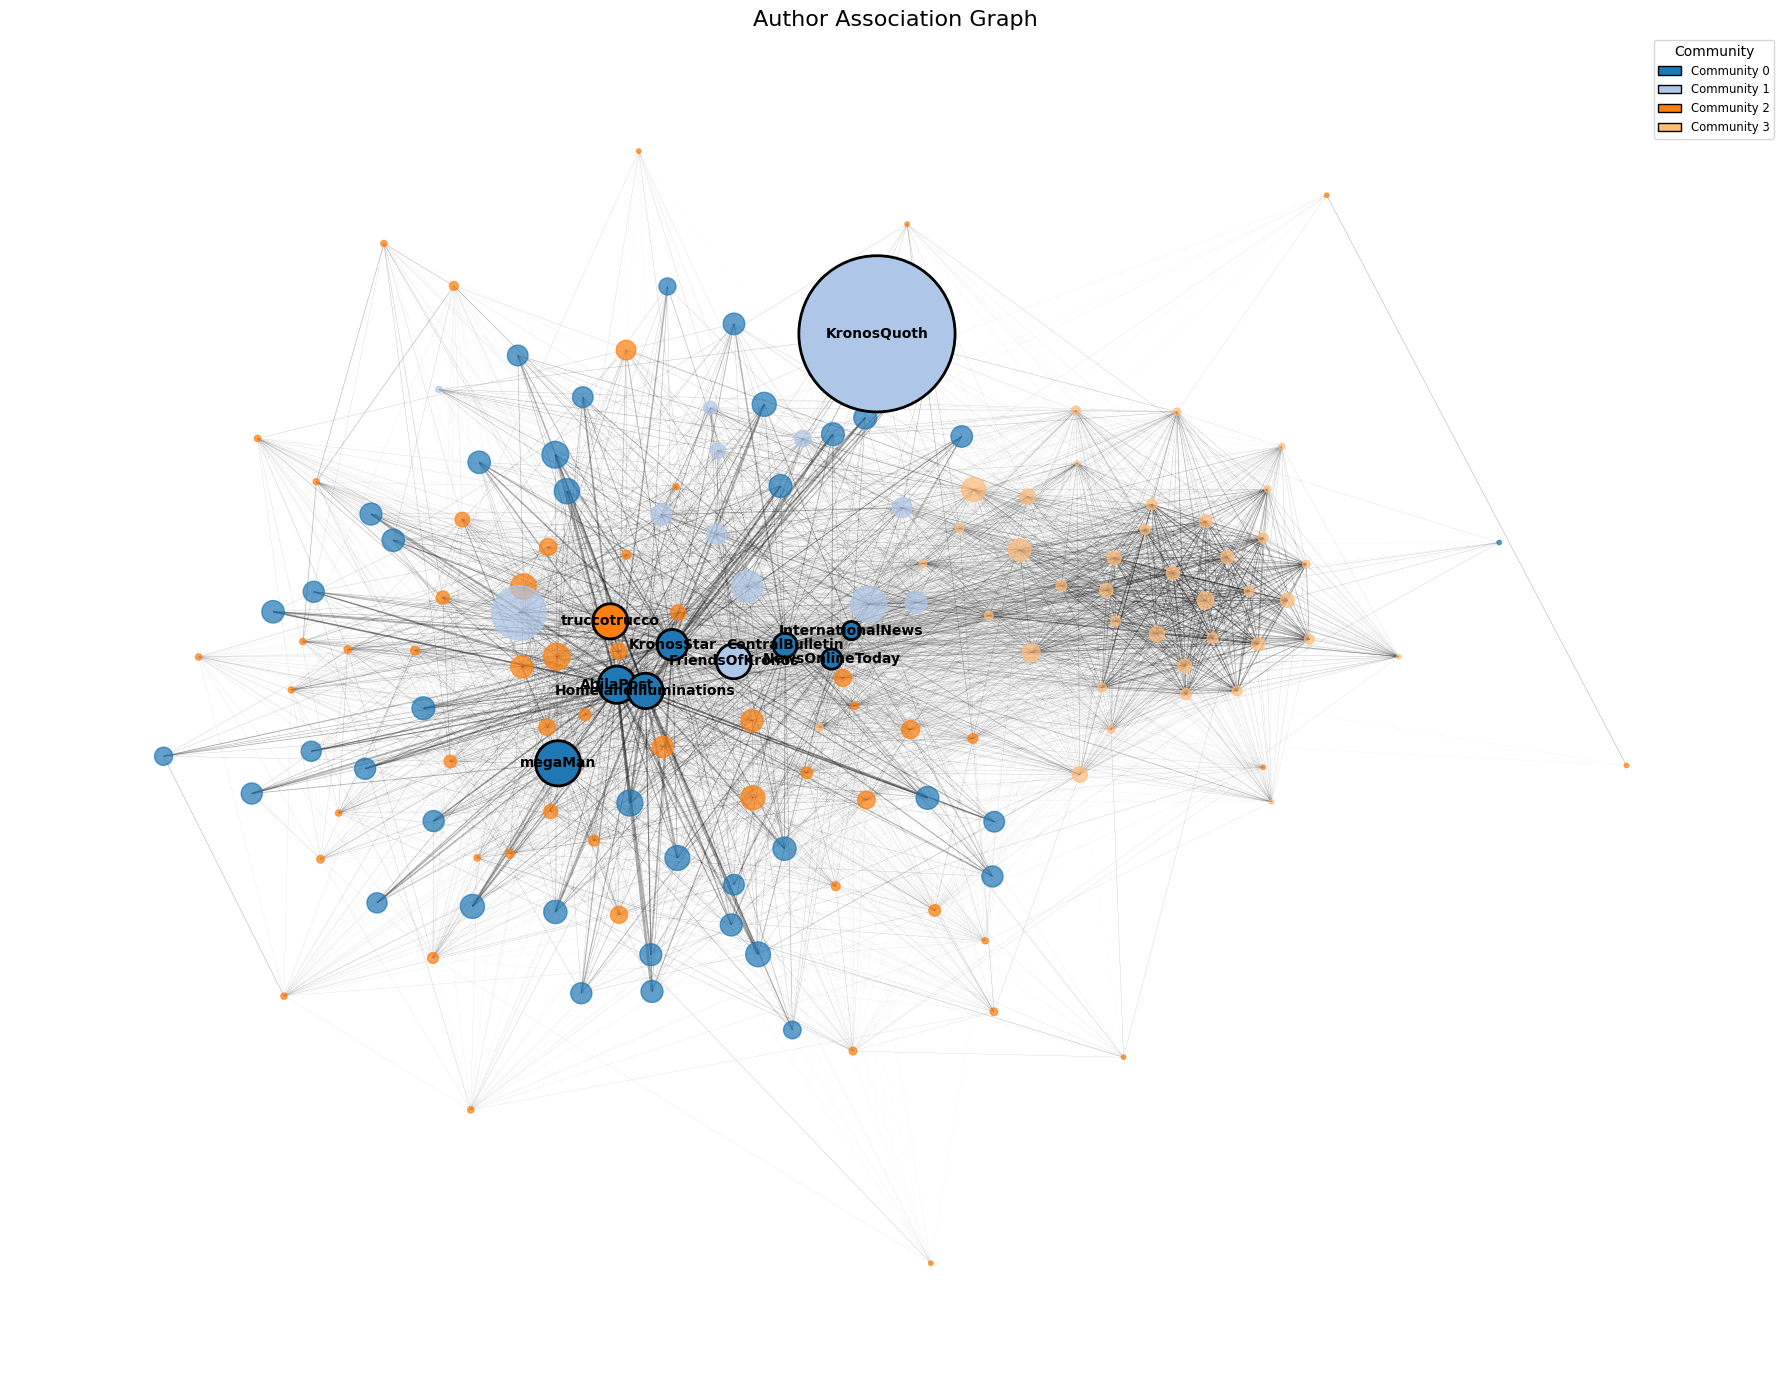

In [164]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import Patch

def draw_author_graph(G, authors, partition=None, df_core=None, mode='community_core', top_n=10, figsize=(18, 14)):
    """
    绘制作者图谱，支持三种模式：
    - 'uniform'：统一颜色，全部作者标注
    - 'community_all'：按社区着色，全部作者标注
    - 'community_core'：按社区着色，仅核心用户标注，边框加粗

    参数：
        G : networkx.Graph
            加权作者图
        authors : dict[str, Author]
            作者名到 Author 实例的映射
        partition : dict[str, int]
            Louvain 社区划分结果：{author: community_id}
        df_core : pd.DataFrame
            包含 author, total_posts, times_retweeted, core_score
        mode : str
            显示模式（见上）
        top_n : int
            仅用于 'community_core' 模式，表示核心用户数量
        figsize : tuple
            图像尺寸
    """
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G, k=0.5, iterations=50)

    # 节点大小
    node_sizes = [authors[n].total_posts * 10 for n in G.nodes()]
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    nx.draw_networkx_edges(G, pos, width=weights, alpha=0.3)

    # 模式 1: uniform
    if mode == 'uniform':
        nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', alpha=0.9)
        nx.draw_networkx_labels(G, pos, font_size=9)

    # 模式 2 & 3: 社区着色
    else:
        # 构建社区颜色映射
        community_ids = sorted(set(partition.values()))
        cmap = plt.cm.tab20
        num_colors = cmap.N
        color_map = {cid: cmap(cid % num_colors) for cid in community_ids}
        node_colors = [color_map[partition[n]] for n in G.nodes()]

        # 模式 2: 全部作者标注
        if mode == 'community_all':
            nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)
            nx.draw_networkx_labels(G, pos, font_size=9)

        # 模式 3: 仅核心用户标注 + 黑边
        elif mode == 'community_core':
            core_users = set(df_core.sort_values(by='core_score', ascending=False).head(top_n)['author'])
            core_nodes = [n for n in G.nodes() if n in core_users]
            other_nodes = [n for n in G.nodes() if n not in core_users]

            # 非核心节点
            nx.draw_networkx_nodes(
                G, pos,
                nodelist=other_nodes,
                node_size=[authors[n].total_posts * 10 for n in other_nodes],
                node_color=[color_map[partition[n]] for n in other_nodes],
                alpha=0.7
            )

            # 核心节点（黑边框）
            nx.draw_networkx_nodes(
                G, pos,
                nodelist=core_nodes,
                node_size=[authors[n].total_posts * 10 for n in core_nodes],
                node_color=[color_map[partition[n]] for n in core_nodes],
                edgecolors='black',
                linewidths=2.0,
                alpha=1.0
            )

            # 只标核心节点名字
            labels = {n: n for n in core_nodes}
            nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_weight='bold')

        # 图例
        legend_elements = [
            Patch(facecolor=color_map[cid], edgecolor='black', label=f"Community {cid}")
            for cid in community_ids
        ]
        plt.legend(handles=legend_elements, title="Community", loc='upper right', fontsize='small')

    plt.title("Author Association Graph", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
draw_author_graph(G_weighted, authors, partition, df_core, mode='community_core', top_n=10)
# draw_author_graph(G_weighted, authors, partition, df_core, mode='community_all')
# draw_author_graph(G_weighted, authors, mode='uniform')

In [166]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def extract_community_topics(partition, authors, num_topics=1, num_words=10):
    """
    为每个社区提取核心 topic（关键词列表）
    """
    from collections import defaultdict

    # 聚合社区作者
    communities = defaultdict(list)
    for user, comm_id in partition.items():
        communities[comm_id].append(user)

    community_topics = {}

    for comm_id, users in communities.items():
        # 收集该社区中所有作者的原创消息
        texts = []
        for user in users:
            author = authors.get(user)
            if author:
                msgs = author.original_df['message'].dropna()
                msgs = msgs[~msgs.str.match(r'^RT\s+@', case=False)]  # 过滤伪转发
                texts.extend(msgs.tolist())

        # 跳过文本太少的社区
        if len(texts) < num_topics:
            community_topics[comm_id] = []
            continue

        # LDA 建模
        vectorizer = CountVectorizer(stop_words='english', max_features=1000)
        X = vectorizer.fit_transform(texts)
        lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
        lda.fit(X)

        words = vectorizer.get_feature_names_out()
        top_keywords = []
        for topic in lda.components_:
            top_words = [words[i] for i in topic.argsort()[-num_words:]]
            top_keywords.append(top_words)

        # 如果只提取一个 topic，就扁平化
        community_topics[comm_id] = top_keywords[0] if num_topics == 1 else top_keywords

    return community_topics


In [167]:
community_topics = extract_community_topics(partition, authors)

for comm_id, keywords in community_topics.items():
    print(f"community {comm_id} keywords: {' '.join(keywords)}")

community 0 keywords: dolphin van apd dancing kronosstar hi police abilapost tag abila
community 1 keywords: don people success grammar rally life pok kronosstar hi pokrally
community 2 keywords: cop people like apd guy van going cops standoff just
community 3 keywords: sow cars meds need online viktor credit followers abila kronos


基于Author Association Graph和community keywords，我们可以推断community 1和community 3是一个相对无关的community （其他community的keywords都出现了van这个已知和时间紧密相关的keywords）
其中community 3中没有core author，近似一个全连接图，且和core authors关系不紧密。
因此我们可以将community 1和3中的所有author的message当作是无关的。（这和S2分析结果吻合）
但这样的筛选粒度比较粗，所以后续可能会有“召回”的可能性。

In [171]:
irrelevant_authors = communities[1] + communities[3]
relevant_authors = set(authors.keys()) - set(irrelevant_authors)

In [175]:
new_partition = {**{author: 0 for author in relevant_authors}, **{author: 1 for author in irrelevant_authors}}
new_community_topics = extract_community_topics(new_partition, authors)

for comm_id, keywords in new_community_topics.items():
    print(f"community {comm_id} keywords: {' '.join(keywords)}")

community 0 keywords: kronosstar hi standoff just apd van abilapost police tag abila
community 1 keywords: success grammar abila rally life kronos pok kronosstar hi pokrally


In [176]:
# 分别统计 total_posts 总和
irrelevant_total = sum(authors[name].total_posts for name in irrelevant_authors)
relevant_total = sum(authors[name].total_posts for name in relevant_authors)

print(f"🛑 Irrelevant authors 共发帖: {irrelevant_total} 条")
print(f"✅ Relevant authors 共发帖: {relevant_total} 条")

🛑 Irrelevant authors 共发帖: 2013 条
✅ Relevant authors 共发帖: 1859 条


### Step 2
**基于规则的方法筛选内容**
1. 关键词
2. 标签

In [192]:
relevant_messages = mbdata_df[mbdata_df['author'].isin(relevant_authors)]
irrelevant_messages = mbdata_df[mbdata_df['author'].isin(irrelevant_authors)]

In [190]:
# 排除advertisements
spam_pattern = r'(http|\.kronos/|click here|#followme)'
filtered_messages = relevant_messages[
    ~relevant_messages['message'].str.contains(spam_pattern, flags=re.IGNORECASE, na=False)
]
filtered_messages.shape

/var/folders/5z/_gp506j901g56ng9m9kp2l480000gn/T/ipykernel_58256/3794992531.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ~relevant_messages['message'].str.contains(spam_pattern, flags=re.IGNORECASE, na=False)


(1841, 9)

可以看到只排除了几条，这进一步证明step1已经把大部分无关的messages排除了

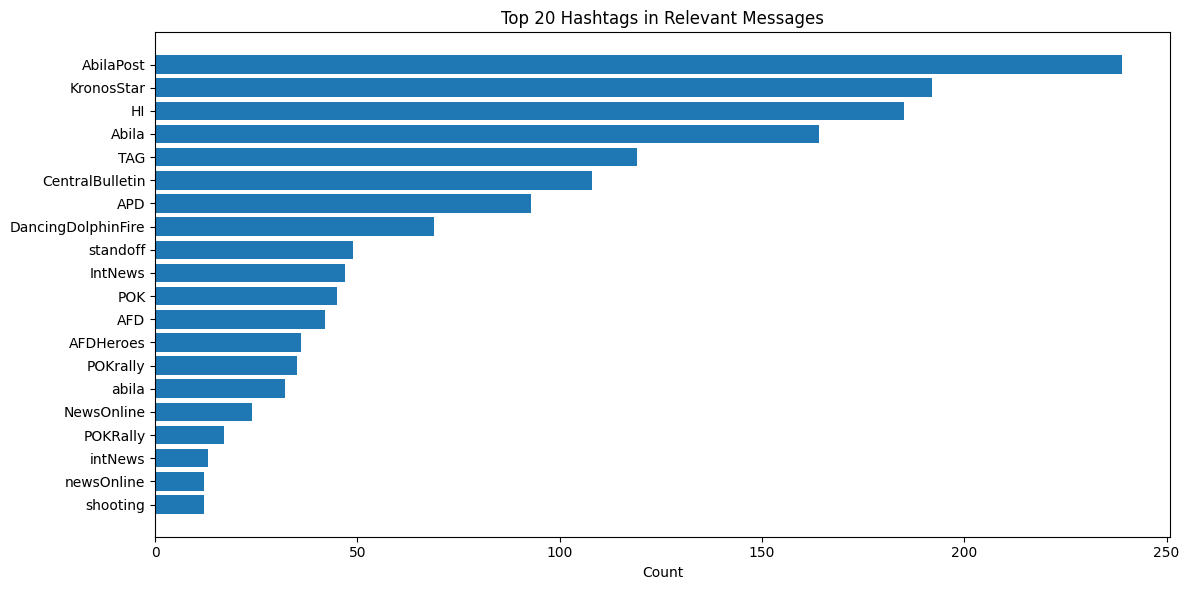

In [ ]:
from itertools import chain
from collections import Counter

relevant_hashtags = list(chain.from_iterable(relevant_messages['hashtags'].to_list()))
hashtag_counts = Counter(relevant_hashtags)

top_n = 20
top_hashtags = hashtag_counts.most_common(top_n)

labels, counts = zip(*top_hashtags)

plt.figure(figsize=(12, 6))
plt.barh(labels, counts)
plt.gca().invert_yaxis()
plt.xlabel("Count")
plt.title(f"Top {top_n} Hashtags in Relevant Messages")
plt.tight_layout()
plt.show()


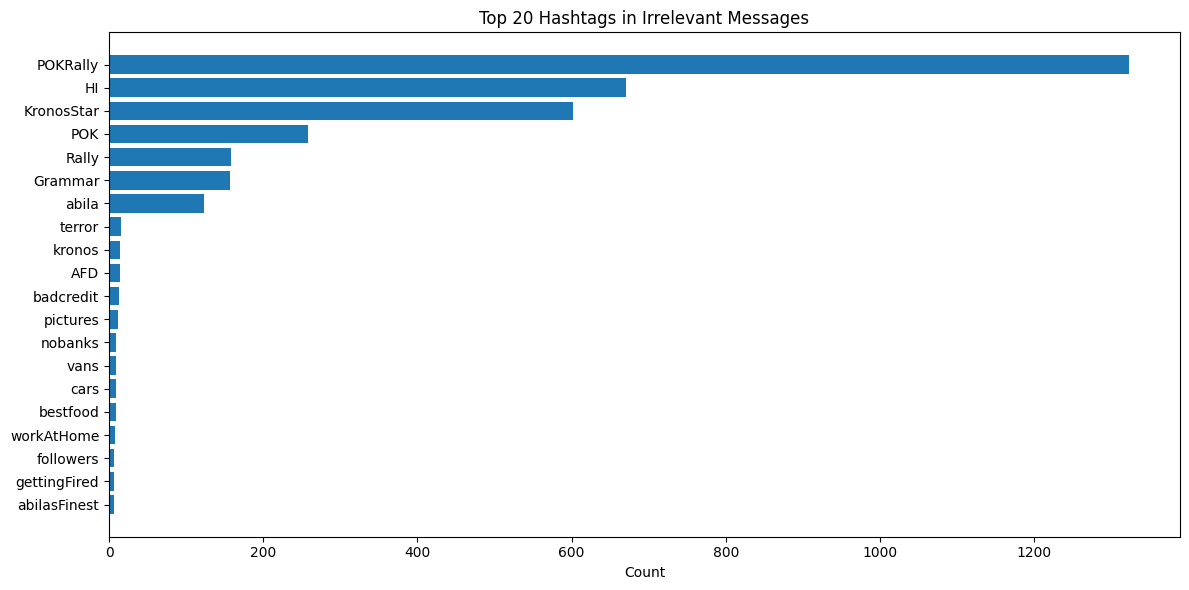

In [200]:
irrelevant_hashtags = list(chain.from_iterable(irrelevant_messages['hashtags'].to_list()))
hashtag_counts = Counter(irrelevant_hashtags)

top_n = 20
top_hashtags = hashtag_counts.most_common(top_n)

labels, counts = zip(*top_hashtags)

plt.figure(figsize=(12, 6))
plt.barh(labels, counts)
plt.gca().invert_yaxis()
plt.xlabel("Count")
plt.title(f"Top {top_n} Hashtags in Irrelevant Messages")
plt.tight_layout()
plt.show()

In [ ]:
HI_messages_df = relevant_messages[
    relevant_messages['hashtags'].apply(lambda x: isinstance(x, list) and 'HI' in x)
]
# HI_messages_df
# HI应该是HomelandIlluminations的缩写，不需要排除

In [203]:
KronosStar_messages_df = irrelevant_messages[
    irrelevant_messages['hashtags'].apply(lambda x: isinstance(x, list) and 'KronosStar' in x)
]
KronosStar_messages_df = relevant_messages[
    relevant_messages['hashtags'].apply(lambda x: isinstance(x, list) and 'KronosStar' in x)
]
# KronosStar_messages_df

我们需要从relevant messages中排除掉一些无关的，同时从irrelevant messages中召回一些有关的。
经过观察发现很难基于hashtags从relevant messages中排除。
而irrelevant messages存在一些hashtags和relevant messages的高频hashtags重合，比如KronosStar, terror, AFD, vans, gettingFired。（经过观察发现KronosStar对应的信息依然是无关的）
因此将这些messages召回。

In [204]:
# 定义相关性关键词
recovery_keywords = {'terror', 'AFD', 'vans', 'gettingFired'}

# 筛选包含这些 hashtags 的消息
recovered_messages = irrelevant_messages[
    irrelevant_messages['hashtags'].apply(
        lambda x: isinstance(x, list) and bool(set(x) & recovery_keywords)
    )
]

print(f"召回消息数: {len(recovered_messages)}")


召回消息数: 46


In [205]:
relevant_messages2 = pd.concat([filtered_messages, recovered_messages], ignore_index=True)

### Step 3
可以对相关信息进行进一步细化
1. 构建ccdata和mbdata的关联，能否从主题相关性的角度将mbdata吸附在ccdata上
    + 需要考虑合理的时空区间
    + 负面情绪